# Project Template: End-to-End AI/ML Pipeline



In [ ]:
import sys
from pathlib import Path

# Add the src directory to Python path for importing project modules
sys.path.append(str(Path.cwd().parent / 'src'))


## Project Introduction


- Objectives & Success Criteria: Define the problem, audience, constraints, and what “good” looks like.
- Metrics vs business KPIs; target thresholds; baseline to beat.
- Assumptions & Scope: What’s in/out, data coverage period, granularity, known limitations.

_______

- Goal: Describe the problem you are solving, who benefits, and how success is measured.
- Scope: Outline the boundaries (what is in/out) and key assumptions.
- KPIs & Metrics: Define primary metrics (e.g., accuracy, F1, AUC, MAPE) and business KPIs.
- Risks & Constraints: Data availability/quality, latency/cost constraints, privacy/compliance.

For example: 
- **Goal.** Train a **compact CycleGAN** that translates **photos → Monet style**, then generate a Kaggle‑ready submission (`images.zip`, 7,000–10,000 images @ 256×256).

- **Deliverables**
    - **Notebook (this file):** EDA → pipeline → model → training → generation → zip → discussion.
    - **GitHub repo:** add this notebook + README + helper scripts.
    - **Kaggle leaderboard screenshot:** after submitting `images.zip`.

- **Why CycleGAN?** Unpaired image‑to‑image translation fits this task: we have Monet paintings and photos but no aligned pairs. We keep the implementation compact and trainable on a modest GPU.




## Data Loading & Initial Inspection


Data Card (short): Sources, ownership, update cadence, schema summary, PII/sensitive fields, licensing.

_______


Load data, take a sneek preview
Tell about the data, for instance:

To kick off our analysis, we’ll load both the BBC News training set (with labels) and the test set (without labels), then merge them into one DataFrame. By combining all articles before any preprocessing, we guarantee that every document — whether destined for model fitting or held out for final scoring — passes through the exact same cleaning and feature-extraction pipeline. Because our core modeling (TF–IDF vectorization + NMF topic extraction) is entirely unsupervised, it never “looks at” the test labels, so there’s no risk of leaking label information. Instead, including test articles up front:
•	Ensures Consistency: Every token is lowercased, stemmed, and filtered for stop-words in the same way, avoiding any inadvertent vocabulary gaps between train and test.
•	Boosts Coverage: Rare words that appear only in test articles still become part of our TF–IDF vocabulary and topic bases, making our latent factors richer and more robust.

After cleaning and factorization, we’ll split back into train/test for hyperparameter tuning (using only train labels) and a final, held-out evaluation on the test labels.

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "src"))

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display  # so display(...) works in both notebook & script

from yourproj.ingest import load_prices, load_earnings
from yourproj.preprocess import align_events
from yourproj.labels import make_day_ahead_label
from yourproj.features import build_structured_features

RAW_PRICES = Path("data/raw/prices.csv")
RAW_EARNINGS = Path("data/raw/earnings.csv")


## Preprocess


### Data Cleaning

Cleaning: Standardize types, handle missing values, de-duplication, scaling.

What we did:
1.	Removed duplicate articles to ensure each text sample is unique.
2.	Dropped any rows with missing values to avoid errors downstream.
3.	Applied a text-cleaning pipeline to each article:
	•	Convert all characters to lowercase
	•	Strip out HTML tags and URLs
	•	Remove any non-alphabetic characters
	•	Tokenize and filter out English stop-words
	•	Stem each token using the Snowball stemmer

Why we did it:
Cleaning the raw text eliminates noise—such as punctuation, numbers, markup, and extremely common words—and reduces words to their root forms. This ensures that when we extract features (e.g. via TF–IDF), the model trains on meaningful, standardized tokens rather than irrelevant or redundant strings.


## Feature Engineering


Transformations: Windowing, aggregations, joins, label construction.<br><br>
Feature Catalog: Keep a short list of features with rationale and leakage checks.


### Align + Label


Aligning price and earnings data, then creating labels for model training


In [ ]:
events = align_events(prices, earnings)
labeled = make_day_ahead_label(events)
feats = build_structured_features(labeled)
display(feats.head())

,ticker,announce_datetime,bmo_amc,eps_actual,eps_estimate,t0_date,close_t0,close_t1,y_d1,surprise
0,AAA,2025-01-01 09:00:00,BMO,1.2,1.0,2025-01-01,10,11.0,1,0.2
1,AAA,2025-01-03 09:00:00,BMO,0.9,1.0,2025-01-03,12,11.0,0,-0.1
2,AAA,2025-01-06 09:00:00,BMO,1.1,1.0,2025-01-06,11,13.0,1,0.1


: 

: 

In [ ]:
# Run preprocess + feature engineering to produce artifacts
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / 'src'))
from yourproj.preprocess import main as preprocess_main
from yourproj.features import main as features_main
CONFIG = 'configs/exp_baseline.yaml'
preprocess_main(CONFIG)
features_main(CONFIG)



## Exploratory Data Analysis


  Use this section to explore distributions, correlations, seasonality, and sanity checks. Capture insights and hypotheses to guide modeling.

In [ ]:
prices = load_prices(RAW_PRICES)
earnings = load_earnings(RAW_EARNINGS)
display(prices.head())
display(earnings.head())

,ticker,date,open,high,low,close,volume
0,AAA,2025-01-01,1,1,1,10,100
1,AAA,2025-01-02,1,1,1,11,100
2,AAA,2025-01-03,1,1,1,12,100
3,AAA,2025-01-06,1,1,1,11,100
4,AAA,2025-01-07,1,1,1,13,100


,ticker,announce_datetime,bmo_amc,eps_actual,eps_estimate
0,AAA,2025-01-01 09:00:00,BMO,1.2,1.0
1,AAA,2025-01-03 09:00:00,BMO,0.9,1.0
2,AAA,2025-01-06 09:00:00,BMO,1.1,1.0


: 

: 


### Example Plot


Visualization of earnings surprise distribution to understand data characteristics


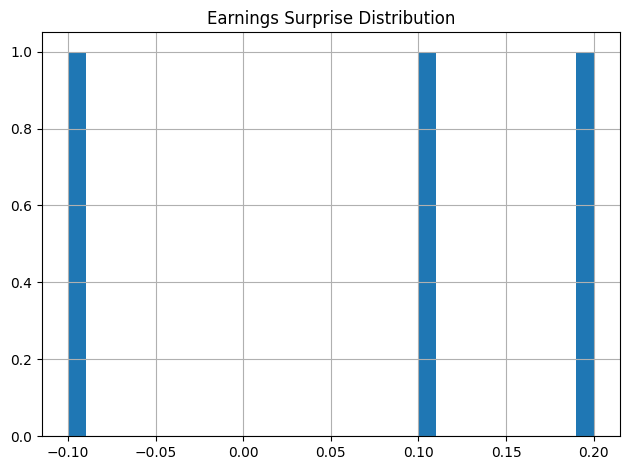

: 

: 

In [ ]:
Path("artifacts/figures").mkdir(parents=True, exist_ok=True)
if not feats.empty and "surprise" in feats:
    ax = feats["surprise"].hist(bins=30)
    ax.set_title("Earnings Surprise Distribution")
    plt.tight_layout()
    plt.savefig("artifacts/figures/surprise_dist.pdf")
    plt.show()


## Models


- Baselines: Start with simple baselines (mean/last value, logistic/linear).
- Candidates: Consider tree-based (RF/XGBoost), linear, neural, or specialized models.
- Hyperparameters: Document search space and defaults.

______

- Experiment Plan: A compact matrix listing planned model families, key features, and parameters to try.


## Training


- Strategy: Train/validation/test split strategy, cross-validation, and seeds.
- Reproducibility: Deterministic seeds, config files, and artifact logging.
- Compute: Hardware, runtime, and cost notes.


____
- Split Strategy & Leakage: Explicitly state split logic (time-aware vs random), test size, and leakage mitigations.
- Reproducibility Checklist: Config use, seeds, artifact locations, environment capture (Python + key pkg versions).

In [ ]:
# Train model using generated features
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / 'src'))
from yourproj.train import main as train_main
CONFIG = 'configs/exp_baseline.yaml'
train_main(CONFIG)


Metrics: {'accuracy': 1.0, 'auc': None, 'features': ['surprise'], 'n_test': 1}
Saved artifacts/figures/metrics.pdf


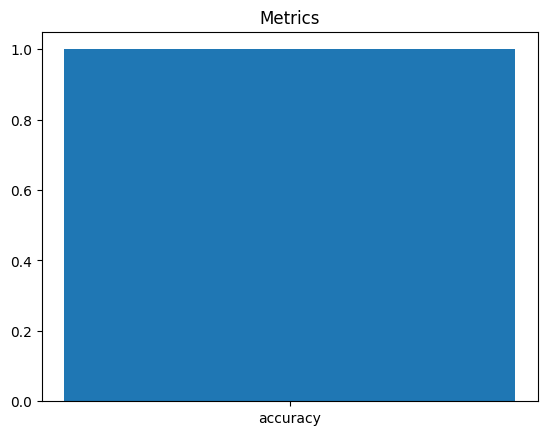

: 

: 

: 

In [ ]:
# Evaluate model and save simple plots
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / 'src'))
from yourproj.eval import main as eval_main
CONFIG = 'configs/exp_baseline.yaml'
eval_main(CONFIG)



## Evaluation


- Metrics: Primary and secondary metrics; calibration and confidence intervals if applicable.
- Error Analysis: Segment performance by cohort/time; investigate failure modes.
- Reporting: Figures/tables for stakeholders and decision makers.

____

- Error Analysis Plan: Cohorts, time slices, and failure-mode checks (class imbalance, drift).
- Decisions Log: A running list of major decisions with brief rationale (e.g., “Chose chrono split due to event causality”).


## Conclusion and Next Steps



## Resources


- **TF–IDF Vectorizer API**  
  Official docs for TfidfVectorizer (parameters like ngram_range, min_df, max_features, etc.)  
  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- **Text Analytics Tutorial**  
  End-to-end guide: load raw text, vectorize with TF–IDF, train a linear classifier  
  https://scikit-learn.org/1.4/tutorial/text_analytics/working_with_text_data.html

- **TF–IDF Math & Intuition**  
  Blog post with mathematical derivation, code examples, and visual intuition for term- and document-frequency weighting  
  https://medium.com/@rohit_batra/multi-class-text-classification-with-scikit-learn-using-tf-idf-model-161d395ce374

- **Logistic Regression API**  
  Full parameter reference (`solver`, `C`, `penalty`, `class_weight`, etc.) including valid ranges and examples  
  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html